In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
#First thing first, lets load the csv files
relax_users = pd.read_csv('takehome_users.csv', encoding='cp1252')
relax_users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


In [2]:
relax_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [3]:
relax_user_engage = pd.read_csv('takehome_user_engagement.csv')
relax_user_engage

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
...,...,...,...
207912,2013-09-06 06:14:15,11996,1
207913,2013-01-15 18:28:37,11997,1
207914,2014-04-27 12:45:16,11998,1
207915,2012-06-02 11:55:59,11999,1


## Objective
Identify which factors predict future user adoption. 'Adopted user' a user who has logged into the product on three separate days in at least one seven-day period. 

In [4]:
# create target variable 'adopted_user'
# We will need to aggregate by user_id and week (one seven day)
relax_user_engage.time_stamp = pd.to_datetime(relax_user_engage.time_stamp)
relax_user_engage = relax_user_engage.set_index('time_stamp')
relax_user_engage



,user_id,visited
time_stamp,,
2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1
...,...,...
2013-09-06 06:14:15,11996,1
2013-01-15 18:28:37,11997,1
2014-04-27 12:45:16,11998,1


In [5]:
user_engage_g = relax_user_engage.groupby('user_id').resample('1W').sum()

In [6]:
#drop user_id duplicates
user_engage_g = user_engage_g.drop('user_id', axis=1)


In [7]:
# create user active weeks
active_weeks = (user_engage_g['visited']>=3)*1
active_weeks = active_weeks.groupby(level=0).sum()
active_weeks = pd.DataFrame(active_weeks, index=active_weeks.index)
active_weeks.columns = ['active_weeks']
active_weeks

,active_weeks
user_id,
1,0
2,1
3,0
4,0
5,0
...,...
11996,0
11997,0
11998,0


In [8]:
#merge dataframes 

relax_data = relax_users.merge(active_weeks, how='left', left_on='object_id', right_index=True)
#create 'adopted_user' using 'active_weeks' column
relax_data['adopted_user'] = [1 if x>=1 else 0 for x in relax_data.active_weeks]
relax_data

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active_weeks,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0.0,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0.0,0


In [9]:
relax_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
active_weeks                  8823 non-null float64
adopted_user                  12000 non-null int64
dtypes: float64(3), int64(5), object(4)
memory usage: 1.1+ MB


Drop unnecessary features 
+ `active_weeks` used to create `adopted_user` keeping it will cause collinearity 
+ datetime variables defined the target variable - `creation_time`, `last_session_creation_time`
+ we do not expect `name` and `email` to play any role in predicting 'adopted_user' - even if it does it may be due to some unknown cofounding variable, also its business application will be complicated. So, they are out. 
+ `invited_by_user_id` is reflected in the `creation_source`

In [10]:
relax_data = relax_data.drop(['active_weeks', 'creation_time', 'last_session_creation_time', 'name', 'email', 'invited_by_user_id'], axis=1)
relax_data

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user
0,1,GUEST_INVITE,1,0,11,0
1,2,ORG_INVITE,0,0,1,1
2,3,ORG_INVITE,0,0,94,0
3,4,GUEST_INVITE,0,0,1,0
4,5,GUEST_INVITE,0,0,193,0
...,...,...,...,...,...,...
11995,11996,ORG_INVITE,0,0,89,0
11996,11997,SIGNUP_GOOGLE_AUTH,0,0,200,0
11997,11998,GUEST_INVITE,1,1,83,0
11998,11999,PERSONAL_PROJECTS,0,0,6,0


In [11]:
#we need to create dummy variables for the categorical variable - 'creation_source'
relax_data = pd.get_dummies(data=relax_data, columns=['creation_source'])
relax_data

,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,1,0,11,0,1,0,0,0,0
1,2,0,0,1,1,0,1,0,0,0
2,3,0,0,94,0,0,1,0,0,0
3,4,0,0,1,0,1,0,0,0,0
4,5,0,0,193,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,0,0,89,0,0,1,0,0,0
11996,11997,0,0,200,0,0,0,0,0,1
11997,11998,1,1,83,0,1,0,0,0,0
11998,11999,0,0,6,0,0,0,1,0,0


### Visualize 

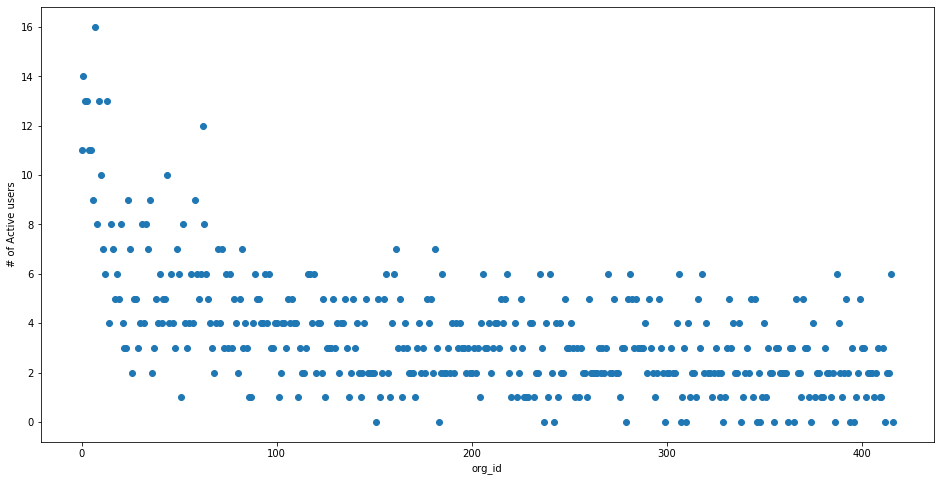

In [12]:
user_by_org = relax_data.groupby('org_id').sum()
# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(16, 8))
plt.scatter(user_by_org.index, user_by_org.adopted_user)
plt.ylabel('# of Active users')
plt.xlabel('org_id')
plt.show()

[Text(0.5, 1, 'Correlations: Adopted Users Correlation')]

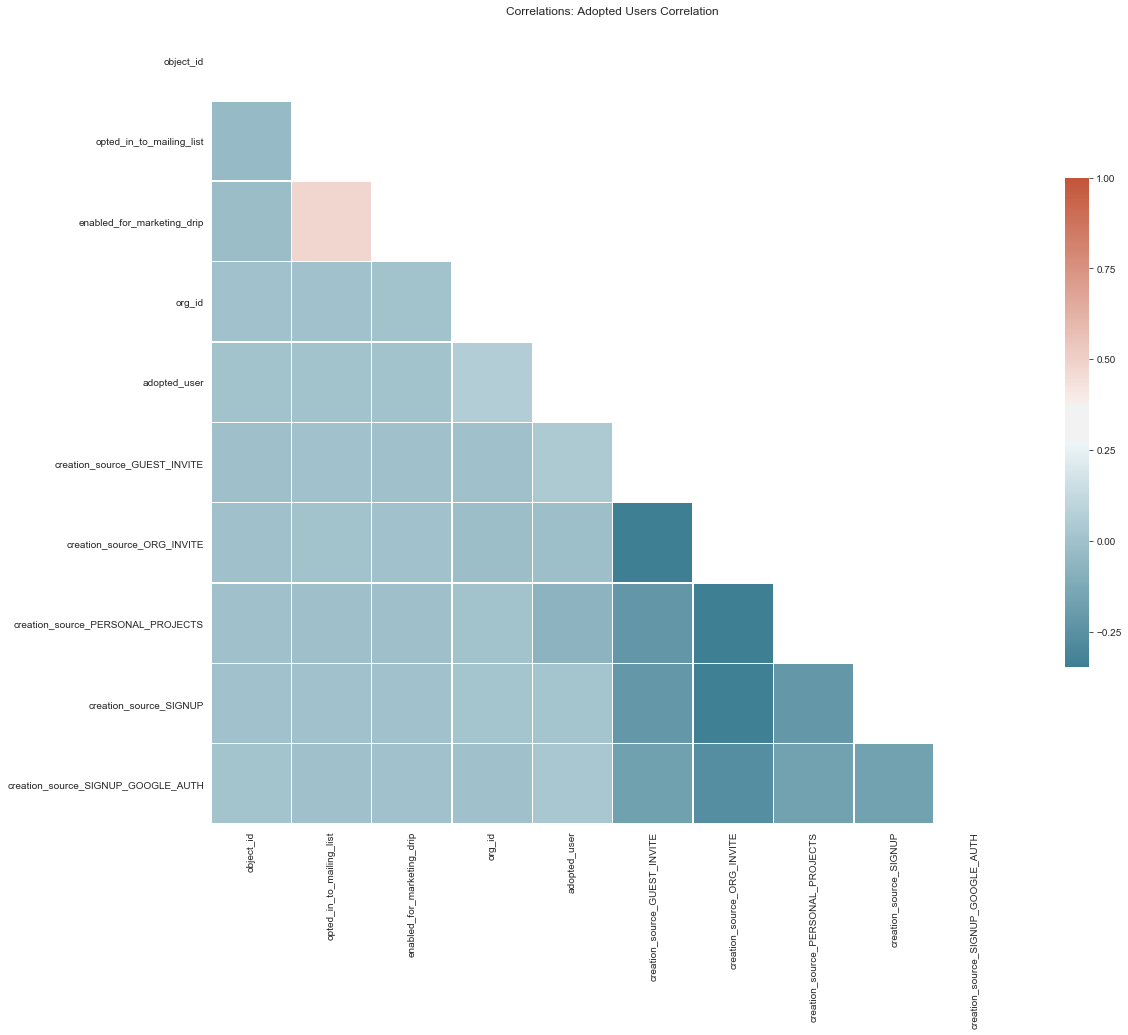

In [13]:

# Compute correlations
corr = relax_data.corr()

# Exclude duplicate correlations by masking uper right values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set background color / chart style
sns.set_style(style = 'white')

# Set up  matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Add diverging colormap
#cmap =sns.diverging_palette(150, 275, s=80, l=55, n=12)
cmap = sns.diverging_palette(220, 20, sep=20, as_cmap=True)

# Draw correlation plot
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
ax.set (title='Correlations: Adopted Users Correlation')

### Build a predictive model 

Identify which factors predict future user adoption. 'Adopted user' a user who has logged into the product on three separate days in at least one seven-day period.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

C:\Users\abebu\DS\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\abebu\DS\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\abebu\DS\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The co

In [15]:
# Check how balanced the dataset is 
relax_data.adopted_user.mean()

0.12041666666666667

Only 12% of the users are adopted_users we will need to upsample our training sample using [SMOTE](https://github.com/scikit-learn-contrib/imbalanced-learny)

In [16]:
# preprocessing
x =  relax_data.drop('adopted_user', axis=1)
y = relax_data.adopted_user

In [17]:
#split into training/testing sets with 20% split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [22]:
def upsample_SMOTE(x_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=42, sampling_strategy=ratio)
    x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)
    print(len(x_train_sm), len(y_train_sm))
    return x_train_sm, y_train_sm

In [28]:
x_train_sm, y_train_sm = upsample_SMOTE(x_train, y_train)

16894 16894


C:\Users\abebu\DS\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [29]:
print (pd.Series(y_train_sm).value_counts())

1    8447
0    8447
dtype: int64


In [30]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(x_train_sm, x_test, y_train_sm, y_test):
    #Names of models
    model_name_list = ['Logistic Regression', 'Random Forest', 'Extra Trees',
                       'Gradient Boosted']
    model = np.arange(1, 5)
    train_accuracy = np.empty(len(model))
    test_accuracy = np.empty(len(model))
    # Instantiate the models
    model1 = LogisticRegression(solver='lbfgs')
    model2 = RandomForestClassifier(n_estimators=100)
    model3 = ExtraTreesClassifier(n_estimators=100)
    model4 = GradientBoostingClassifier(n_estimators=100)
    results =pd.DataFrame(columns=['train_accuracy', 'test_accuracy', 'AUC'])    
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4]):
        model.fit(x_train_sm, y_train_sm)
        
        train_accuracy=model.score(x_train_sm, y_train_sm)
        test_accuracy=model.score(x_test, y_test)
        y_pred = model.predict(x_test)
        auc = roc_auc_score(y_test, y_pred)
        
        model_name=model_name_list[i]
        results.loc[model_name, :] =[train_accuracy, test_accuracy, auc]
    return results

In [31]:
results = evaluate (x_train_sm, x_test, y_train_sm, y_test)
results

,train_accuracy,test_accuracy,AUC
Logistic Regression,0.833195,0.878333,0.5
Random Forest,1,0.814583,0.509439
Extra Trees,1,0.803333,0.50156
Gradient Boosted,0.837694,0.876667,0.500526


Lets redo the models without oversampling the training set

In [33]:
# Evaluate several ml models by training on training set and testing on testing set
def evaluate(x_train, x_test, y_train, y_test):
    #Names of models
    model_name_list = ['Logistic Regression', 'Random Forest', 'Extra Trees',
                       'Gradient Boosted']
    model = np.arange(1, 5)
    train_accuracy = np.empty(len(model))
    test_accuracy = np.empty(len(model))
    # Instantiate the models
    model1 = LogisticRegression(solver='lbfgs')
    model2 = RandomForestClassifier(n_estimators=100)
    model3 = ExtraTreesClassifier(n_estimators=100)
    model4 = GradientBoostingClassifier(n_estimators=100)
    results =pd.DataFrame(columns=['train_accuracy', 'test_accuracy', 'AUC'])    
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4]):
        model.fit(x_train, y_train)
        
        train_accuracy=model.score(x_train, y_train)
        test_accuracy=model.score(x_test, y_test)
        y_pred = model.predict(x_test)
        auc = roc_auc_score(y_test, y_pred)
        
        model_name=model_name_list[i]
        results.loc[model_name, :] =[train_accuracy, test_accuracy, auc]
    return results

In [34]:
results = evaluate(x_train, x_test, y_train, y_test)
results

,train_accuracy,test_accuracy,AUC
Logistic Regression,0.879896,0.878333,0.5
Random Forest,0.999792,0.8625,0.504263
Extra Trees,1,0.848333,0.503574
Gradient Boosted,0.881042,0.8775,0.501001


It looks like the oversmapling the minority class (adopted users) may have destroyed the majority class of the training set. With the sufficient sample size we have oversampling maybe unecessary. 

In [39]:
model4 = GradientBoostingClassifier(n_estimators=100)
model4.fit(x_train, y_train)
feature_imp = pd.DataFrame(model4.feature_importances_).transpose()
feature_imp.columns = list(x.columns)
feature_imp.index = ['GBC_Coef']
feature_imp.transpose().sort_values(by='GBC_Coef', ascending=False)

,GBC_Coef
object_id,0.506119
org_id,0.309596
creation_source_PERSONAL_PROJECTS,0.090875
creation_source_ORG_INVITE,0.038593
creation_source_GUEST_INVITE,0.030310
creation_source_SIGNUP_GOOGLE_AUTH,0.013627
enabled_for_marketing_drip,0.005990
creation_source_SIGNUP,0.004035
opted_in_to_mailing_list,0.000856


### Conculusion 

The Gradient Boosting Classsifier and Logistics Regression have predicted 88% of training and test accuracy adopted users. However, the area under the curve score shows us our model were not any better than a random chance. The AUC score of 50% shows that half of the time our model predicts a false positivee. This is probably the features in the dataset are not good predictors of the target variable - adopted users. The importance of features table shows the users id as an important prdictor, taking us back to the main question, what about the users is important to predict adopted users? 

